# EBLP Block Covariance Matrix $G$ Estimation - Attempts to Iteratively Estimate its Cholesky Factor  

In [3]:
#import cvxpy as cp
import collections
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy.optimize
import scipy.sparse
from numpy.linalg import norm

import eblp
import eblp.cov_estimate as cov

np.set_printoptions(linewidth=150, precision=2, suppress=False)

%load_ext autoreload
%autoreload 2

## Load Example Data

In [4]:
#DATA_DIR = "../data/RealDataExample"
DATA_DIR = "../data/Oren_example"
a_file_name = os.path.join(DATA_DIR, "A.txt")
c_file_name = os.path.join(DATA_DIR, "C.txt")
w_file_name = os.path.join(DATA_DIR, "Weights_BxB.txt")
pi_file_name = os.path.join(DATA_DIR, "Pi_s.txt")
a, c, w, r, p = eblp.data.load_data(a_file_name, c_file_name, w_file_name, pi_file_name)

## Check Existing Solution Quality
Baseline residual from Katherine's R-code: $\|f(G^*)\|/\|C\| \approx 0.04$.

G = A G* A'
lam(G^*) [-1.7e+01 -6.8e+00  8.4e-02  8.2e+00  1.8e+01  4.0e+01  6.3e+01  6.8e+01  1.1e+02  1.6e+02  1.9e+02]
lam [-1.9e+01 -1.3e+01  4.2e-15  1.3e-01  1.7e+01  2.4e+01  4.6e+01  6.3e+01  7.3e+01  1.2e+02  1.7e+02  2.0e+02]
res 0.0408

G = edited(A G* A')
lam [1.8e-15 3.2e-14 9.6e-14 1.3e-01 1.7e+01 2.4e+01 4.6e+01 6.3e+01 7.3e+01 1.2e+02 1.7e+02 2.0e+02]
res 0.0847

G = A edited(G*) A'
lam [-5.9e-14  1.7e-14  1.0e-13  1.5e-01  1.7e+01  2.8e+01  4.9e+01  6.3e+01  7.5e+01  1.2e+02  1.7e+02  2.0e+02]
res 0.1118



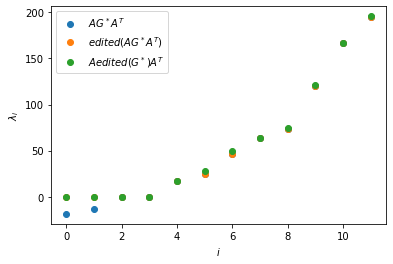

In [6]:
gs = np.loadtxt(os.path.join(DATA_DIR, "Gstar.txt"))
g = a @ gs @ a.T
lam = np.sort(np.linalg.eig(g)[0])
lam_g = np.sort(np.linalg.eig(gs)[0])
print("G = A G* A'")
print("lam(G^*) {}".format(np.array2string(lam_g, precision=1)))
print("lam {}".format(np.array2string(lam, precision=1)))
print("res {:.4f}".format(norm(cov.f(gs, p) - c) / norm(c)))
print("")

g_edited = np.loadtxt(os.path.join(DATA_DIR, "G.txt"))
lam_edited = np.sort(np.linalg.eig(g_edited)[0])
print("G = edited(A G* A')")
print("lam {}".format(np.array2string(lam_edited, precision=1)))
print("res {:.4f}".format(norm(cov.f(g_edited, r) - c) / norm(c)))
print("")

gs_edited = np.loadtxt(os.path.join(DATA_DIR, "Gstar_edited.txt"))
g2_edited = a @ gs_edited @ a.T
lam2_edited = np.sort(np.linalg.eig(g2_edited)[0])
print("G = A edited(G*) A'")
print("lam {}".format(np.array2string(lam2_edited, precision=1)))
print("res {:.4f}".format(norm(cov.f(g2_edited, r) - c) / norm(c)))
print("")

plt.plot(lam, 'o', label="$A G^* A^T$")
plt.plot(lam_edited, 'o', label="$edited(A G^* A^T$)")
plt.plot(lam2_edited, 'o', label="$A edited(G^*) A^T$")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.legend();

#gs = np.loadtxt(os.path.join(data_dir, "Gstar.txt"))
#lam = np.sort(np.linalg.eig(gs)[0])

## Reproducing Current Solution Procedure

### Recoding $G^*$ to a vector
Each $f$-term is of the form $P G^* P^T$. More generally, when we write $G^* = LL^T$ and freeze one of the terms in the Cholesky product, we will obtain terms of the form $P L L_{prev}^T P^T = P L (P L_{prev})^T = P L Q^T$ where $P \not = Q$. So we first focus on recoding the function 

$$h(G) := P G Q^T$$ 

into the form $H g$, where $g$ consists of the lower-dimensional part of $G$ (including the diagonal). Here
* $P: m \times n$.
* $G: n \times n$.
* $Q: m \times n$.
* $F: \frac{m (m+1)}{2} \times \frac{n (n+1)}{2}$.
* $g$: vector of size $\frac{n (n+1)}{2}$.

In the original equations, $m = B, n = B - 1$, and $Q = P$ in all terms appearing in $f$.

$$ (h(G))_{ij} = (P LG Q^T)_{ij} = \sum_{l,k=0}^{n-1} P_{ik} Q_{jk} G_{kl} = \sum_{r=0}^{n(n-1)/2} P_{ik} Q_{jk} g_{r(k,l)}$$

In [7]:
# Set up the flattened system to solve for G^*.
H = cov.matrix_function_to_matrix_sum(p, p)
c_vector = eblp.linalg.unravel_lower(c)

In [8]:
# Full sanity check of flattened (matrix * vector) vs. original matrix function.
D = cov.norm_weight_matrix(p[0].shape[0])
H = cov.matrix_function_to_matrix_sum(p, p)
c_vector = eblp.linalg.unravel_lower(c)

# Variable G, lower triangular part, flattened.
g = cov.unravel_solution_matrix(gs)

# Matrix function, lower triangular part, flattened.
f_unraveled = eblp.linalg.unravel_lower(cov.f(gs, p))
n = len(c_vector)
print("Difference between f(G) and h(G) = {:.2e}".format(
    norm(f_unraveled.flatten() - (H @ g).flatten()) / n))

%time g_vector = np.linalg.lstsq(H, c_vector, rcond=None)[0]
print("Difference between G^* loaded from file and LS solution = {:.2e}".format(
    norm(np.array(g_vector).flatten() - np.array(g).flatten()) / n))

print("LS problem size", H.shape)
print("LS residual",
      "Flattened", norm(D @ (H @ g_vector - c_vector)) / norm(D @ (c_vector)), 
      "Original", norm((cov.f(gs, p) - c)/norm(c)))

gs_edited_vector = cov.unravel_solution_matrix(gs_edited)

print("LS residual of G*_edited", 
      "Flattened", norm(D @ (H @ gs_edited_vector - c_vector)) / norm(D @ (c_vector)), 
      "Original", norm((cov.f(gs_edited, p) - c)/norm(c)))

Difference between f(G) and h(G) = 2.52e-14
CPU times: user 1.25 ms, sys: 98 µs, total: 1.35 ms
Wall time: 701 µs
Difference between G^* loaded from file and LS solution = 1.66e-14
LS problem size (78, 66)
LS residual Flattened 0.04079483888841204 Original 0.04079483888841188
LS residual of G*_edited Flattened 0.11178333880319918 Original 0.11178333880319881


In [9]:
# A small change in the solution G^* causes a large change in function value f.
g_vector = np.linalg.lstsq(H, c_vector, rcond=None)[0]
gs = cov.ravel_solution_matrix(g_vector)
gs = gs + gs.T - np.diag(np.diag(gs))
lam, q = np.linalg.eig(gs)
gs_truncated = q @ np.diag(np.clip(lam, 1e-5, None)) @ q.T
print(norm((cov.f(gs, p) - c)/norm(c)), norm((cov.f(gs_truncated, p) - c)/norm(c)))
print(norm(gs_truncated - gs_edited) / norm(gs_edited))

0.04079483888841205 0.11178345241600336
4.791283929485247e-08


In [10]:
(cov.f(gs, p) - c)/norm(c), (cov.f(gs, p) - c)/norm(c)

(array([[-0.004, -0.001, -0.002, -0.004, -0.003, -0.002, -0.009, -0.001, -0.003, -0.006, -0.004, -0.003],
        [-0.001,  0.003,  0.006,  0.003,  0.003,  0.005, -0.002,  0.006,  0.005,  0.001,  0.003,  0.005],
        [-0.002,  0.006,  0.002,  0.002,  0.002,  0.004, -0.004,  0.005,  0.004, -0.   ,  0.002,  0.004],
        [-0.004,  0.003,  0.002, -0.   ,  0.   ,  0.002, -0.006,  0.003,  0.001, -0.003, -0.001,  0.001],
        [-0.003,  0.003,  0.002,  0.   ,  0.   ,  0.002, -0.005,  0.003,  0.001, -0.002, -0.   ,  0.002],
        [-0.002,  0.005,  0.004,  0.002,  0.002,  0.002, -0.003,  0.004,  0.003, -0.   ,  0.002,  0.003],
        [-0.009, -0.002, -0.004, -0.006, -0.005, -0.003, -0.005, -0.002, -0.004, -0.008, -0.006, -0.004],
        [-0.001,  0.006,  0.005,  0.003,  0.003,  0.004, -0.002,  0.002,  0.004,  0.   ,  0.002,  0.004],
        [-0.003,  0.005,  0.004,  0.001,  0.001,  0.003, -0.004,  0.004,  0.001, -0.001,  0.001,  0.003],
        [-0.006,  0.001, -0.   , -0.003, -0.00

<!-- ## School Fixed Effect Constraints
The original problem for $G$ (instead of $G^*$) is a zero-sum constrained least squares:

$$ \min_g \|f(G) - C \|^2_2 $$
$$ 1^T G = 0 $$

Recoding into a flattened form, this beecomes

$$ \min_g \| F g - c \|^2_2 $$
$$ R g = 0 $$ -->

In [11]:
# g_edited.sum(axis=0)

## Fixed-point Iteration

The Bunch-Kaufman factorization of a PSD matrix is (https://en.wikipedia.org/wiki/Symmetric_matrix#Decomposition)

$$ f(G^*) = \sum_P P G^* P^T = C $$

$$ A = \Pi^T L D L^T \Pi $$

where $L$ is a unit triangular matrix and $D$ s a direct sum of symmetric $1 \times 1 and$ $2\times 2$ blocks.

In [15]:
# Set up the LS problem min||H*g - c||_2.
D = cov.norm_weight_matrix(p[0].shape[0])
H = cov.matrix_function_to_matrix_sum(p, p)
c_vector = eblp.linalg.unravel_lower(c)
residual = lambda g_vector: norm(D @ (H @ g_vector - c_vector)) / norm(D @ (c_vector))

# Initial guess: edited G^*.
gs_init = gs_edited

### Variant 1: Iterate on $L$, freeze $D L^T$ term

In [16]:
gs = gs_init
l, d, perm = scipy.linalg.ldl(gs)
P = eblp.linalg.row_permutation_matrix(perm)
l = l[perm]
print(np.diag(d), perm, norm(gs - P.T @ l @ d @ l.T @ P) / norm(gs), np.allclose(l, np.tril(l)))
print(l)
l_vector = cov.unravel_solution_matrix(l)
i = 0

H_frozen = cov.matrix_function_to_matrix_sum(p @ P.T, p @ (P.T @ l @ d.T), lower=True)
rg = residual(cov.unravel_solution_matrix(gs))
rl = norm(D @ (H_frozen @ l_vector - c_vector)) / norm(D @ (c_vector))
print("{:<4s} {:<12s} {:<12s} {:<12s}".format("Iter", "LS Residual", "L-residual", "G-residual"))
print("{:<4d} {:<12s} {:<12.3e} {:<12.3e}".format(i, "", rl, rg))

num_iterations = 8
for i in range(1, num_iterations + 1):
    l_vector = np.linalg.lstsq(H_frozen, c_vector, rcond=None)[0]
    r_ls = norm(D @ (H_frozen @ l_vector - c_vector)) / norm(D @ (c_vector))

    l = cov.ravel_solution_matrix(l_vector)
    gs = P.T @ l @ d @ l.T @ P
    rg = residual(cov.unravel_solution_matrix(gs))
    H_frozen = cov.matrix_function_to_matrix_sum(p @ P.T, p @ (P.T @ l @ d.T), lower=True)
    rl = norm(D @ (H_frozen @ l_vector - c_vector)) / norm(D @ (c_vector))
    print("{:<4d} {:<12.3e} {:<12.3e} {:<12.3e}".format(i, r_ls, rl, rg))
    #print(l)

[ 5.663e+01  2.441e+01  6.158e+01  1.674e+01  9.253e+01  4.704e+01  2.986e+01  1.168e+01  2.057e-01 -1.629e-13
  3.927e-13] [ 0  1  2  3  4  5  6  8  7  9 10] 1.3933473921472232e-16 True
[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.554  1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.334  0.144  1.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.021  0.509 -0.001  1.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.226 -0.564  0.153 -0.18   1.     0.     0.     0.     0.     0.     0.   ]
 [-0.495 -0.221  0.004  0.705 -0.151  1.     0.     0.     0.     0.     0.   ]
 [ 0.05   0.095 -0.86  -0.577 -0.371 -0.192  1.     0.     0.     0.     0.   ]
 [-0.379 -0.24   0.277 -1.022 -0.181  0.385 -0.451  1.     0.     0.     0.   ]
 [-0.19   0.479 -0.513  0.193 -0.123 -0.213 -0.116 -0.508  1.     0.     0.   ]
 [ 0.393 -0.976 -0.032  0.621 -0.328 -0.666  0.036  0.303 -0.583  1.     0.   ]
 [-0.269  0.5

### Variant 2: Lump $D$ into $L$

In [17]:
gs = gs_init
l, d, perm = scipy.linalg.ldl(gs)
P = eblp.linalg.row_permutation_matrix(perm)
l = l[perm] @ np.diag(np.clip(np.diag(d), 0, None) ** 0.5)
print(np.diag(d), perm, norm(gs - P.T @ l @ l.T @ P) / norm(gs), np.allclose(l, np.tril(l)))
print(l)
l_vector = cov.unravel_solution_matrix(l)
i = 0

H_frozen = cov.matrix_function_to_matrix_sum(p @ P.T, p @ (P.T @ l), lower=True)
rg = residual(cov.unravel_solution_matrix(gs))
rl = norm(D @ (H_frozen @ l_vector - c_vector)) / norm(D @ (c_vector))
print("{:<4s} {:<12s} {:<12s} {:<12s}".format("Iter", "LS Residual", "L-residual", "G-residual"))
print("{:<4d} {:<12s} {:<12.3e} {:<12.3e}".format(i, "", rl, rg))

num_iterations = 5
for i in range(1, num_iterations + 1):
    l_vector = np.linalg.lstsq(H_frozen, c_vector, rcond=None)[0]
    r_ls = norm(D @ (H_frozen @ l_vector - c_vector)) / norm(D @ (c_vector))

    l = cov.ravel_solution_matrix(l_vector)
    gs = P.T @ l @ d @ l.T @ P
    rg = residual(cov.unravel_solution_matrix(gs))
    H_frozen = cov.matrix_function_to_matrix_sum(p @ P.T, p @ (P.T @ l), lower=True)
    rl = norm(D @ (H_frozen @ l_vector - c_vector)) / norm(D @ (c_vector))
    print("{:<4d} {:<12.3e} {:<12.3e} {:<12.3e}".format(i, r_ls, rl, rg))
    #print(l)

[ 5.663e+01  2.441e+01  6.158e+01  1.674e+01  9.253e+01  4.704e+01  2.986e+01  1.168e+01  2.057e-01 -1.629e-13
  3.927e-13] [ 0  1  2  3  4  5  6  8  7  9 10] 1.102403672970152e-15 True
[[ 7.526e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00]
 [-4.167e+00  4.941e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00]
 [ 2.512e+00  7.129e-01  7.847e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00]
 [-1.559e-01  2.514e+00 -8.833e-03  4.092e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00]
 [ 1.702e+00 -2.785e+00  1.203e+00 -7.385e-01  9.619e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00]
 [-3.724e+00 -1.093e+00  3.061e-02  2.883e+00 -1.455e+00  6.858e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00]
 [ 3.750e-01  4.685e-01 -6.752e+00 -2.359e+00 -3.567e+00 -

### Variant 3: Fully Non-Linear in $L$
Using scipy's black-box minimizer to minimize $\|h(L L^T) - c\|_2^2$ (slow). 
* Slightly worse than editing $G$, better than editing $G^*$.
* Has $2$ zero eigenvalues as opposed to $3$ when editing $G^*$ or $G$.

In [18]:
gs = gs_init
rg = residual(cov.unravel_solution_matrix(gs))

l, d, perm = scipy.linalg.ldl(gs)
P = eblp.linalg.row_permutation_matrix(perm)
l = l[perm]
l_vector = cov.unravel_solution_matrix(l)
i = 0


def f(l_vector):
    l = cov.ravel_solution_matrix(l_vector)
    return residual(cov.unravel_solution_matrix(P.T @ l @ d @ l.T @ P)) ** 2
print("{:<4d} {:<12s} {:<12.3e} {:<12.3e}".format(i, "", rg, f(l_vector) ** 0.5))

result = scipy.optimize.fmin(f, l_vector, full_output=True)
print("Minimizer residual", f(result[0]) ** 0.5)

0                 1.118e-01    1.118e-01   
Minimizer residual 0.08718102385029575


Our G^*'
lam [-9.8e-15  7.3e-13  7.2e-02  1.1e+01  1.7e+01  3.8e+01  6.4e+01  6.8e+01  1.1e+02  1.6e+02  1.9e+02]
res 0.0872

edited(G^*)
lam [-5.9e-14  1.7e-14  1.0e-13  1.5e-01  1.7e+01  2.8e+01  4.9e+01  6.3e+01  7.5e+01  1.2e+02  1.7e+02  2.0e+02]
res 0.1118



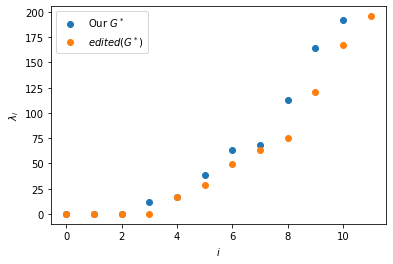

In [19]:
l = cov.ravel_solution_matrix(result[0])
gs = P.T @ l @ d @ l.T @ P
lam = np.sort(np.linalg.eig(gs)[0])
print("Our G^*'")
print("lam {}".format(np.array2string(lam, precision=1)))
print("res {:.4f}".format(norm(cov.f(gs, p) - c) / norm(c)))
print("")

gs_edited = np.loadtxt(os.path.join(DATA_DIR, "Gstar_edited.txt"))
lam_edited = np.sort(np.linalg.eig(g2_edited)[0])
print("edited(G^*)")
print("lam {}".format(np.array2string(lam_edited, precision=1)))
print("res {:.4f}".format(norm(cov.f(gs_edited, p) - c) / norm(c)))
print("")

plt.plot(lam, 'o', label="Our $G^*$")
plt.plot(lam_edited, 'o', label="$edited(G^*)$")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.legend();

#gs = np.loadtxt(os.path.join(data_dir, "Gstar.txt"))
#lam = np.sort(np.linalg.eig(gs)[0])

### Variant 4: Positive Definite $G^*$
Avoiding zero eigenvalues may reduce bias in diagonal elements according to JR.

In [385]:
# Add eps*identity to make initial guess PD.
gs = gs_edited.copy()
np.fill_diagonal(gs, np.diag(gs) + 0.0001)

rg = residual(cov.unravel_solution_matrix(gs))
l = scipy.linalg.cholesky(gs, lower=True)
l_vector = cov.unravel_solution_matrix(l)
i = 0

a = D @ H
b = D @ c_vector

def f(l_vector):
    l = cov.ravel_solution_matrix(l_vector)
    g_vector = cov.unravel_solution_matrix(l @ l.T)
#    return residual(cov.unravel_solution_matrix(l @ l.T)) ** 2
    return norm(a @ g_vector - b) ** 2

print("{:<4d} {:<12s} {:<12.3e} {:<12.3e}".format(i, "", rg, f(l_vector) ** 0.5 / norm(b)))

%time result = scipy.optimize.fmin(f, l_vector, full_output=True)
l = cov.ravel_solution_matrix(result[0])
g_vector = cov.unravel_solution_matrix(l @ l.T)
print("Minimizer residual", residual(cov.unravel_solution_matrix(l @ l.T)))

0                 1.118e-01    1.118e-01   
CPU times: user 3.75 s, sys: 117 ms, total: 3.87 s
Wall time: 1.9 s
Minimizer residual 0.0871422895047293


In [367]:
# def f_ls(l_vector):
#     l = cov.ravel_solution_matrix(l_vector)
#     g_vector = cov.unravel_solution_matrix(l @ l.T)
#     return (a @ g_vector - b).flatten()

# %time result = scipy.optimize.least_squares(f_ls, l_vector, method="lm")

# l = cov.ravel_solution_matrix(result.x)
# g_vector = cov.unravel_solution_matrix(l @ l.T)
# print("Minimizer residual", residual(cov.unravel_solution_matrix(l @ l.T)))

Our G^*'
lam [1.5e-04 3.1e-04 2.6e-01 1.1e+01 1.8e+01 3.9e+01 6.4e+01 6.8e+01 1.1e+02 1.6e+02 1.9e+02]
res 0.0871

edited(G^*)
lam [-5.9e-14  1.7e-14  1.0e-13  1.5e-01  1.7e+01  2.8e+01  4.9e+01  6.3e+01  7.5e+01  1.2e+02  1.7e+02  2.0e+02]
res 0.1118



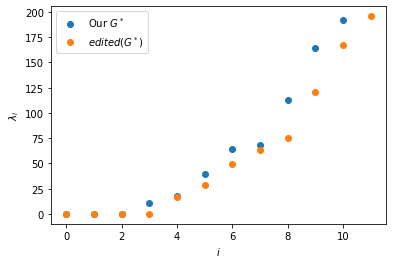

In [368]:
# l = cov.ravel_solution_matrix(result[0])
gs = l @ l.T
lam = np.sort(np.linalg.eig(gs)[0])
print("Our G^*'")
print("lam {}".format(np.array2string(lam, precision=1)))
print("res {:.4f}".format(norm(cov.f(gs, p) - c) / norm(c)))
print("")

gs_edited = np.loadtxt(os.path.join(DATA_DIR, "Gstar_edited.txt"))
lam_edited = np.sort(np.linalg.eig(g2_edited)[0])
print("edited(G^*)")
print("lam {}".format(np.array2string(lam_edited, precision=1)))
print("res {:.4f}".format(norm(cov.f(gs_edited, p) - c) / norm(c)))
print("")

plt.plot(lam, 'o', label="Our $G^*$")
plt.plot(lam_edited, 'o', label="$edited(G^*)$")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.legend();

#gs = np.loadtxt(os.path.join(data_dir, "Gstar.txt"))
#lam = np.sort(np.linalg.eig(gs)[0])

In [369]:
l

array([[ 7.401e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00],
       [-4.438e+00,  4.644e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00],
       [ 2.503e+00,  8.849e-01,  7.866e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00],
       [-1.200e-01,  2.526e+00, -5.857e-03,  4.412e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00],
       [ 1.713e+00, -2.902e+00,  1.280e+00, -6.203e-01,  9.565e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00],
       [-3.811e+00, -1.580e+00,  1.933e-02,  2.838e+00, -1.689e+00,  6.731e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00],
       [ 5.684e-01,  8.383e-01, -6.884e+00, -2.305e+00, -3.439e+00, -1.235e+00,  5.190e+00,  0.000e+00,  0

In [371]:
# g = a @ gs @ a.T
# lam = np.sort(np.linalg.eig(g)[0])
# print(lam)

In [372]:
lam[0], lam_edited[0]

(0.00015279872616982604, -5.872580431013797e-14)

## Variant 4A: Cholesky/PD, Iterate on $L$

In [373]:
# %%time

# # Add eps*identity to make initial guess PD.
# gs = gs_edited
# np.fill_diagonal(gs, np.diag(gs) + 1e-2)

# rg = residual(cov.unravel_solution_matrix(gs))
# l = scipy.linalg.cholesky(gs, lower=True)
# l_vector = cov.unravel_solution_matrix(l)
# i = 0

# H_frozen = cov.matrix_function_to_matrix_sum(p, p @ l, lower=True)
# rg = residual(cov.unravel_solution_matrix(gs))
# rl = norm(D @ (H_frozen @ l_vector - c_vector)) / norm(D @ (c_vector))
# print("{:<4s} {:<12s} {:<12s} {:<12s}".format("Iter", "LS Residual", "L-residual", "G-residual"))
# print("{:<4d} {:<12s} {:<12.3e} {:<12.3e}".format(i, "", rl, rg))

# num_iterations = 8
# for i in range(1, num_iterations + 1):
#     l_vector = np.linalg.lstsq(H_frozen, c_vector, rcond=None)[0]
#     r_ls = norm(D @ (H_frozen @ l_vector - c_vector)) / norm(D @ (c_vector))

#     l = cov.ravel_solution_matrix(l_vector)
#     gs = l @ l.T
#     rg = residual(cov.unravel_solution_matrix(gs))
#     H_frozen = cov.matrix_function_to_matrix_sum(p, p @ l, lower=True)
#     rl = norm(D @ (H_frozen @ l_vector - c_vector)) / norm(D @ (c_vector))
#     print("{:<4d} {:<12.3e} {:<12.3e} {:<12.3e}".format(i, r_ls, rl, rg))
#     #print(l)

Still unstable. Maybe it means $L^T$ cannot just be frozen.

## Explicit Equation for the flattened $L$

In [396]:
n = gs_edited.shape[0]
lower_index = np.array(list(itertools.combinations(range(n), 2)))
k = np.concatenate((np.arange(n), lower_index[:, 1]))
l = np.concatenate((np.arange(n), lower_index[:, 0]))
ind = -np.ones((n, n), dtype=int)
ind[k, l] = np.arange(len(k))
element_of_pair = dict(((r, s), j) for j in range(N) for r, s in zip(ind[k[j]], ind[l[j]]) if r >= 0 and s >= 0)

M, N = a.shape
data = np.concatenate(tuple(
    np.concatenate((np.arange(M)[:, None], np.tile((r, s), (M, 1)),  a[:, j][:, None]), axis=1)
    for (r, s), j in element_of_pair.items()
), axis=0)
data = data[data[:, 0].argsort()]
endpoints = np.concatenate(([0], np.where(np.diff(data[:, 0]) != 0)[0] + 1, [data.shape[0]]))
w_sparse = [scipy.sparse.csr_matrix(
        (data[endpoints[i]:endpoints[i + 1], 3], 
        (data[endpoints[i]:endpoints[i + 1], 1], data[endpoints[i]:endpoints[i + 1], 2])),
        shape=(N, N))
            for i in range(M)]

In [397]:
print(ind)
print(k, l)

M, N = a.shape
# Sanity check.
# Each (r, s) = l[r] * l[s] combination appears in exactly one g[j] entry where l = flattened L and
# g = flattened G. Not all (r, s) pairs are present.
# for j in range(N):
#     print(j, (k[j], l[j]), [(r, s) for r,  s in zip(ind[k[j]], ind[l[j]]) if r >= 0 and s >= 0])
pair_counter = collections.Counter((r, s) for j in range(N) for r, s in zip(ind[k[j]], ind[l[j]]) if r >= 0 and s >= 0)
print(len(pair_counter))
assert all(v == 1 for v in pair_counter.values())

w2 = np.zeros((M, N, N))
for j in range(N):
    for (r, s) in ((r, s) for r,  s in zip(ind[k[j]], ind[l[j]]) if r >= 0 and s >= 0):
        for i, hij in enumerate(a[:, j]):
            # if r == 0 and s == 0:
            #     print(i, "j", j, (k[j], l[j]), ind[k[j]], ind[l[j]], r, s, hij)
            w2[i, max(r, s), min(r, s)] += hij
            
w = np.zeros((M, N, N))
for (r, s), j in element_of_pair.items():
        w[:, r, s] = a[:, j]
        
print(norm(w - w2), max(norm(w_sparse[i].todense() - w[i]) for i in range(M)))
print(M * N * N,  len(np.where(w != 0)[0]), sum(wi.nnz for wi in w_sparse))

[[ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [11  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [12 21  2 -1 -1 -1 -1 -1 -1 -1 -1]
 [13 22 30  3 -1 -1 -1 -1 -1 -1 -1]
 [14 23 31 38  4 -1 -1 -1 -1 -1 -1]
 [15 24 32 39 45  5 -1 -1 -1 -1 -1]
 [16 25 33 40 46 51  6 -1 -1 -1 -1]
 [17 26 34 41 47 52 56  7 -1 -1 -1]
 [18 27 35 42 48 53 57 60  8 -1 -1]
 [19 28 36 43 49 54 58 61 63  9 -1]
 [20 29 37 44 50 55 59 62 64 65 10]]
[ 0  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  2  3  4  5  6  7  8  9 10  3  4  5  6  7  8  9 10  4
  5  6  7  8  9 10  5  6  7  8  9 10  6  7  8  9 10  7  8  9 10  8  9 10  9 10 10] [ 0  1  2  3  4  5  6  7  8  9 10  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  3
  3  3  3  3  3  3  4  4  4  4  4  4  5  5  5  5  5  6  6  6  6  7  7  7  8  8  9]
286
0.0 0.0
339768 22308 22308


In [413]:
def f(l_vector):
    l = cov.ravel_solution_matrix(l_vector)
    g_vector = cov.unravel_solution_matrix(l @ l.T)
#    return residual(cov.unravel_solution_matrix(l @ l.T)) ** 2
    return norm(a @ g_vector - b) ** 2


def f2(x):
    return sum((x.T @ ai @ x - bi) ** 2 for ai, bi in zip(w, b))

def grad(x):
    return 2 * sum((x.T @ ai @ x - bi) * (ai + ai.T) @ x for ai, bi in zip(w, b))

l = result[0]
f(l_vector) ** 0.5 / norm(b), f2(l_vector) ** 0.5 / norm(b)

(0.11178600525526722, 0.11178600525526754)

In [473]:
gs = gs_init
l, d, perm = scipy.linalg.ldl(gs)
P = eblp.linalg.row_permutation_matrix(perm)
l = l[perm]
l_vector_init = cov.unravel_solution_matrix(l)

In [474]:
%time x = scipy.optimize.fmin_l_bfgs_b(f2, l_vector_init, grad)
#print(x)
print(x[1] ** 0.5 / norm(b), x[2]['funcalls'])

l_vector = x[0]
l = cov.ravel_solution_matrix(l_vector)
g = l.T @ l
np.sort(np.linalg.eig(g)[0])

CPU times: user 446 ms, sys: 17 ms, total: 463 ms
Wall time: 463 ms
0.08435174996637289 261


array([1.89e-09, 1.61e-08, 5.99e-01, 1.14e+01, 1.78e+01, 3.91e+01, 6.36e+01, 6.82e+01, 1.13e+02, 1.64e+02, 1.92e+02])

In [476]:
%time result = scipy.optimize.fmin(f, l_vector, full_output=True)
print(result)
print(f(result[0]) ** 0.5 / norm(b))

l_vector = result[0]
l = cov.ravel_solution_matrix(l_vector)
g = l.T @ l
np.sort(np.linalg.eig(g)[0])

Optimization terminated successfully.
         Current function value: 265077.353008
         Iterations: 1604
         Function evaluations: 2471
CPU times: user 331 ms, sys: 5.4 ms, total: 337 ms
Wall time: 335 ms
(array([ 7.43e+00,  4.80e+00,  7.87e+00,  4.56e+00,  9.59e+00,  6.87e+00,  5.51e+00,  2.26e+00,  2.18e+00,  1.80e-04, -1.20e-04, -4.32e+00,  2.53e+00,
       -1.38e-01,  1.70e+00, -3.81e+00,  3.83e-01, -1.45e+00, -2.88e+00,  2.98e+00, -2.09e+00,  7.58e-01,  2.38e+00, -2.90e+00, -1.41e+00,  3.94e-01,
        2.48e+00, -1.40e+00, -4.86e+00,  2.67e+00, -1.03e-02,  1.21e+00,  6.68e-02, -6.73e+00, -4.05e+00,  2.20e+00, -2.44e-01,  3.24e-01, -7.10e-01,
        2.57e+00, -1.83e+00,  3.24e-01, -3.61e+00,  1.81e+00, -1.30e+00, -1.61e+00, -3.55e+00, -1.15e+00, -1.77e+00, -3.31e+00,  4.34e+00, -1.69e+00,
       -1.10e+00,  2.00e+00, -4.43e+00, -1.77e+00, -8.88e-01, -1.81e+00, -7.70e-01,  6.78e-02, -4.06e+00,  8.71e-01, -2.13e+00, -1.64e+00,  1.11e+00,
       -1.63e-04]), 265077.353008

array([1.98e-09, 1.68e-08, 5.99e-01, 1.14e+01, 1.78e+01, 3.91e+01, 6.36e+01, 6.82e+01, 1.13e+02, 1.64e+02, 1.92e+02])

## Regularization
Maximize $G'$'s, i.e. $L$'s determinant, under constant norm.

$$ \min_l \sum_i \left(l^T A_i l - c_i\right)^2 - \alpha \left(
\sum_{i=0}^{n-1} \log(l_i^2) - \log \left(\sum_{i=0}^{n-1} l_i ^2\right) \right) $$
* Continuation in $\alpha$, starting from large $\alpha$ and decreasing it.
* BFGS for a fixed $\alpha$.
* L-curve for picking $\alpha$.

In [919]:
scale = 1 / norm(b) ** 2

def f_term(x):
    return scale * sum((x.T @ ai @ x - bi) ** 2 for ai, bi in zip(w, b))

def reg_term(x):
    return - sum(np.log(x[:n] ** 2)) + np.log(sum(x[:n] ** 2))

def f_reg(x, alpha):
    return f_term(x) + alpha * reg_term(x)

def grad_reg(x, alpha):
    g = scale * 2 * sum((x.T @ ai @ x - bi) * (ai + ai.T) @ x for ai, bi in zip(w, b))
    g[:n] -= alpha * (2 / x[:n] - 2 * x[:n] / sum(x[:n] ** 2))
    return g

def roc_curve(alpha, l_vector_init, gtol: float = 1e-3):
    #fun = lambda x: f_reg(x, alpha)
    #grad = lambda x: grad_reg(x, alpha)
    #x = scipy.optimize.fmin_l_bfgs_b(fun, l_vector_init, grad)
    result = scipy.optimize.minimize(f_reg, l_vector_init, args=(alpha, ), method='BFGS', jac=grad_reg, options={'gtol': gtol, 'disp': False})
    l_vector = result.x
    l = cov.ravel_solution_matrix(l_vector)
    lam = np.sort(np.linalg.eig(l.T @ l)[0])
    return l_vector, (alpha, f_term(l_vector), lam[-1] / lam[0])

In [967]:
# alpha_values = np.logspace(1, 10, num=20, base=10)
# %time roc = np.array([roc_curve(alpha, l_vector_init) for alpha in alpha_values])

# print(roc)
# plt.semilogy(roc[:, 1], roc[:, 2])
# plt.xlim([0.079, 0.1])
# plt.grid(True);

# def f3_reg(x, alpha):
#     return sum((x.T @ ai @ x - bi) ** 2 for ai, bi in zip(w, b)) \
#         + alpha * ((1 / n) * sum(x[:n] ** 2) - (1 / n ** 2) * np.sum(x[:n]) ** 2)

# def grad3_reg(x, alpha):
#     g = 2 * sum((x.T @ ai @ x - bi) * (ai + ai.T) @ x for ai, bi in zip(w, b))
#     g[:n] += alpha * ((2 / n) * x[:n] - (2 / n ** 2) * np.sum(x[:n]))
#     return g

# def f3_reg(x, alpha):
#     return (1 / n) * sum(x[:n] ** 2) - (1 / n ** 2) * np.sum(x[:n]) ** 2

# def grad3_reg(x, alpha):
#     g = np.zeros_like(x)
#     g[:n] += (2 / n) * x[:n] - (2 / n ** 2) * np.sum(x[:n])
#     return g

# # Gradient check.
# def grad_check(fun, grad, n):
#     np.random.seed(0)
#     x = np.random.random((n,))

#     def unit_vector(n, i):
#         e = np.zeros((n,))
#         e[i] = 1
#         return e

#     delta = 1e-7
#     grad_fd = np.array([(fun(x + delta * unit_vector(n, i)) - fun(x)) / delta for i in range(n)])
#     return norm(grad_fd - grad(x)) / norm(grad(x))

# alpha = 1e30
# fun = lambda x: f3_reg(x, alpha)
# grad = lambda x: grad3_reg(x, alpha)
# print(grad_check(fun, grad, N))

# kneedle = KneeLocator(curve[:, 1], curve[:, 2], S=1.0, curve="convex", direction="decreasing")
# index = np.where(curve[:, 1] == kneedle.knee)[0][0]
# print(kneedle.knee, index, curve[index])

In [968]:
%%time
n = gs_edited.shape[0]
x = np.array([1] * n + [0] * (N - n))
alpha = 100 * np.abs(f_term(x)) / np.abs(reg_term(x))
roc = []
for i in range(5):
    result = roc_curve(alpha, x, gtol=1e-3)
    roc.append(result)
    alpha *= 0.01
    x = result[0]
    
index = min(np.where(curve[:, 1] < 1.3 * min(curve[:, 1]))[0])
alpha = curve[index, 0]
x, info = roc_curve(alpha, roc[index][0], gtol=1e-4)

CPU times: user 7.83 s, sys: 167 ms, total: 8 s
Wall time: 690 ms


[13.97  1.21  0.13  0.1   0.1 ]
[  12.56   20.88  122.91 3384.52 3384.52]
(4.0829018641973366e-05, 0.007321850623050972, 6704.432775488962)


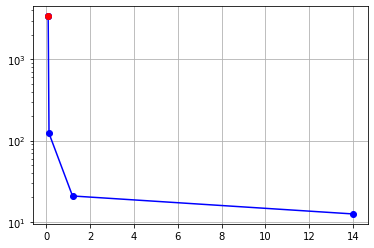

In [966]:
curve = np.array([row[1] for row in roc])
print(curve[:, 1] ** 0.5)
print(curve[:, 2])
plt.semilogy(curve[:, 1] ** 0.5, curve[:, 2], 'b-o')
#plt.xlim([0.079, 0.1])
plt.grid(True);
plt.plot(curve[index, 1] ** 0.5, curve[index, 2], 'ro')
print(info)

In [ ]:
np.array2string(g, separator=" ",)